In [1]:
!pip install evaluate datasets transformers[torch]

zsh:1: no matches found: transformers[torch]


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
import evaluate
import numpy as np
from datasets import load_metric, load_dataset
import random


/opt/homebrew/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [3]:
# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)

In [4]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [5]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [6]:
MODEL = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):  # each example is an element from the Dataset
    return tokenizer(examples["review"], truncation=True)

In [ ]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the
#  length of the longest element in the batch, making them all the same length.
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
sequence_clf_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=5,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sequence_clf_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/57613 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.rename_column("star", "label")
dataset = dataset.remove_columns(['package_name', 'review', 'date'])
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

<Axes: >

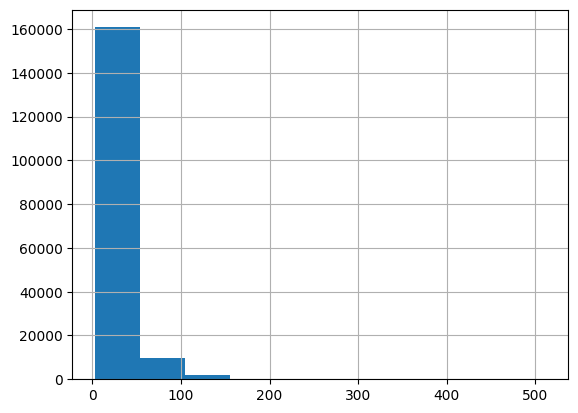

In [ ]:
import pandas as pd

input_ids = dataset['train']['input_ids']
pd.Series(input_ids).apply(len).hist()

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}


In [ ]:
epochs = 1

training_args = TrainingArguments(
    output_dir="./bert_clf_results",
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,

    # some deep learning parameters that the Trainer is able to take in
    warmup_ratio=0.1,
    weight_decay = 0.05,

    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,  # optional
    data_collator=data_collator  # technically optional
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32


{'eval_loss': 1.6827906370162964,
 'eval_accuracy': 0.04603127766302744,
 'eval_runtime': 158.8995,
 'eval_samples_per_second': 362.575,
 'eval_steps_per_second': 11.334}

In [24]:
trainer.train()

***** Running training *****
  Num examples = 172,839
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5,401
  Number of trainable parameters = 65,785,349


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
0,0.980200,0.819233,0.716418


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32


Saving model checkpoint to ./bert_clf_results/checkpoint-5401
Configuration saved in ./bert_clf_results/checkpoint-5401/config.json
Model weights saved in ./bert_clf_results/checkpoint-5401/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./bert_clf_results/checkpoint-5401 (score: 0.819233238697052).


TrainOutput(global_step=5401, training_loss=0.8730425443986548, metrics={'train_runtime': 1405.4036, 'train_samples_per_second': 122.982, 'train_steps_per_second': 3.843, 'total_flos': 3506405066166240.0, 'train_loss': 0.8730425443986548, 'epoch': 0.9999074331204295})

In [25]:
trainer.evaluate(dataset['test'])

***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32


{'eval_loss': 0.8123031258583069,
 'eval_accuracy': 0.717233957613733,
 'eval_runtime': 163.3375,
 'eval_samples_per_second': 352.724,
 'eval_steps_per_second': 11.026,
 'epoch': 0.9999074331204295}

In [9]:
import pandas as pd
# Create a dictionary with your data

data = {
    'Model Description': [
        'Babbage - 1 epoch',
        'Babbage - 4 epochs',
        '3.5 - 1 epoch + no system prompt',
        '3.5 - 1 epoch + system prompt',
        'DistilBERT'
    ],
    'Raw Accuracy': [
        0.6467637512367,
        0.6320795653758701,
        0.6345442868796973,
        0.6442296009581171,
        0.71723395761
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# To make it more readable, let's round the numeric values to a fixed number of decimal places:
df_rounded = df.round(5)
df_rounded

,Model Description,Raw Accuracy
0,Babbage - 1 epoch,0.64676
1,Babbage - 4 epochs,0.63208
2,3.5 - 1 epoch + no system prompt,0.63454
3,3.5 - 1 epoch + system prompt,0.64423
4,DistilBERT,0.71723


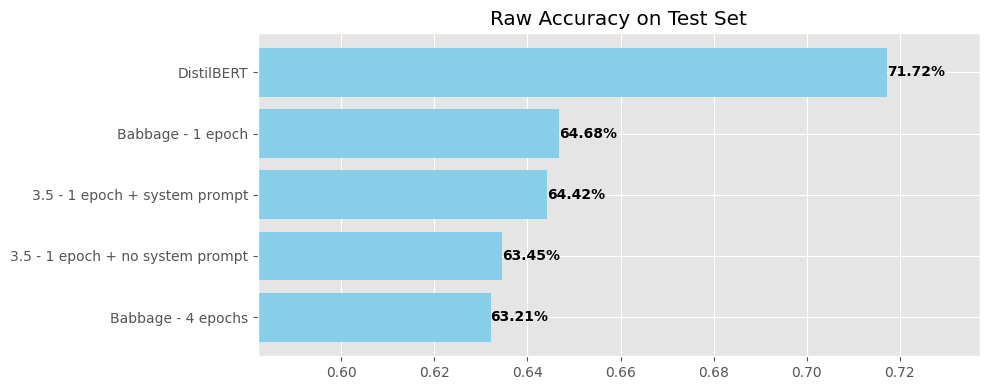

In [19]:
import matplotlib.pyplot as plt

# Find the minimum accuracy values for setting xlim
min_raw_accuracy = min(df_rounded['Raw Accuracy']) - 0.05
max_raw_accuracy = max(df_rounded['Raw Accuracy']) + 0.02

# Set the style
plt.style.use('ggplot')

# Define figure and axis for the accuracy plot
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust the figure size as needed

df_rounded.sort_values('Raw Accuracy', inplace=True, ascending=True)

ax.barh(df_rounded['Model Description'], df_rounded['Raw Accuracy'], color='skyblue')
ax.set_title('Raw Accuracy on Test Set')
ax.set_xlim(min_raw_accuracy, max_raw_accuracy)  # Extend the x-axis
for i, v in enumerate(df_rounded['Raw Accuracy']):
    ax.text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')

# Adjust the layout
plt.tight_layout()

# Show the plot for accuracy
plt.show()
